In [27]:
import pandas
import numpy
from matplotlib import pyplot
import os
import ROOT

In [28]:
times = {"cores":[],"mean":[],"meanerr":[],"throughput_GB_s":[]}
timedir = "hl-d102-20211111-2numanode-16cores/appruntimes"
datasetsize = 157400503680
readpercent = 0.7949011466389114
readsize = 112940757600
for f in os.listdir(timedir):
    array = numpy.genfromtxt(timedir+"/"+f, skip_header=1)
    nodes = f.split("_")[4].replace("cores.csv","")
    time_mean = numpy.mean(array)
    times["cores"].append(int(nodes))
    times["mean"].append(round(time_mean, 2))
    times["meanerr"].append(round(numpy.std(array)/numpy.sqrt(len(array)), 2))
    times["throughput_GB_s"].append(readsize/time_mean/pow(10, 9))
    
timesdf = pandas.DataFrame(times)
timesdf = timesdf.sort_values(by="cores").reset_index(drop=True).copy()
timesdf

,cores,mean,meanerr,throughput_GB_s
0,1,164.30,1.06,0.687417
1,2,93.89,1.11,1.202888
2,4,50.26,1.13,2.247160
3,6,36.90,0.30,3.060753
4,8,28.37,0.31,3.980790
5,10,24.09,0.26,4.688370
6,12,20.52,0.16,5.502625
7,14,19.24,0.13,5.871288
8,16,17.25,0.25,6.547122


In [29]:
throughput_1node = timesdf["throughput_GB_s"][0]
timesdf["throughputspeedup"] = timesdf["throughput_GB_s"] / throughput_1node
timesdf

,cores,mean,meanerr,throughput_GB_s,throughputspeedup
0,1,164.30,1.06,0.687417,1.000000
1,2,93.89,1.11,1.202888,1.749866
2,4,50.26,1.13,2.247160,3.268989
3,6,36.90,0.30,3.060753,4.452539
4,8,28.37,0.31,3.980790,5.790936
5,10,24.09,0.26,4.688370,6.820268
6,12,20.52,0.16,5.502625,8.004780
7,14,19.24,0.13,5.871288,8.541083
8,16,17.25,0.25,6.547122,9.524231


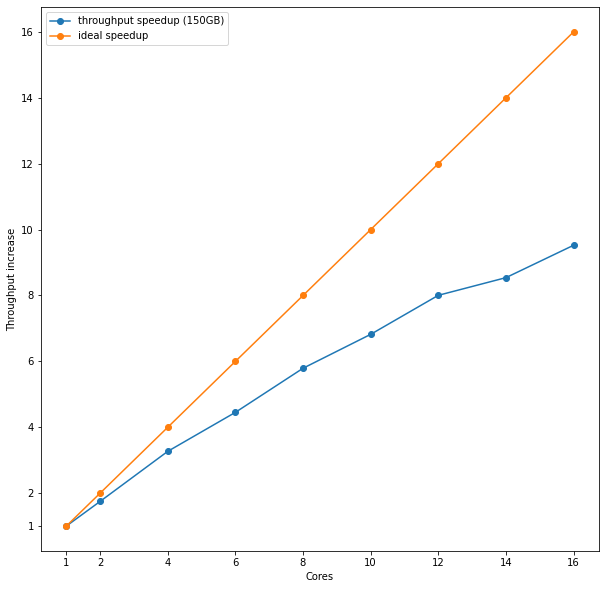

In [30]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["cores"], timesdf["throughputspeedup"], label="throughput speedup (150GB)", marker="o")
pyplot.plot(timesdf["cores"], timesdf["cores"], label="ideal speedup", marker="o")
pyplot.xticks(timesdf["cores"])
pyplot.yticks(timesdf["cores"])
pyplot.xlabel("Cores")
pyplot.ylabel("Throughput increase")
pyplot.legend()

No handles with labels found to put in legend.


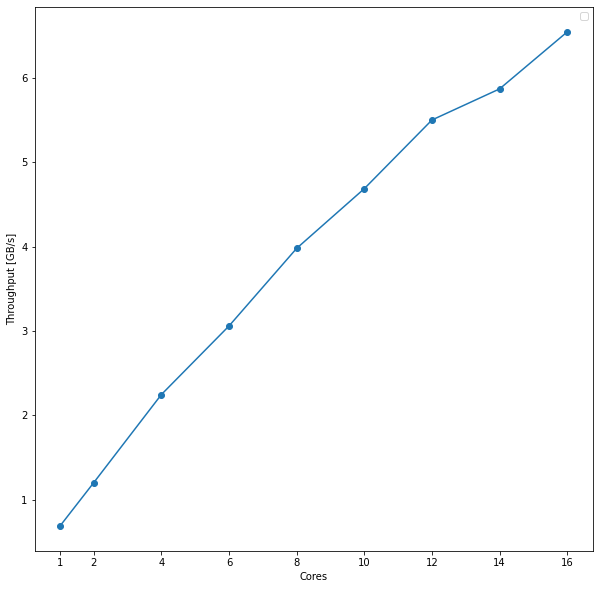

In [31]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["cores"], timesdf["throughput_GB_s"], marker="o")
pyplot.xticks(timesdf["cores"])

pyplot.xlabel("Cores")
pyplot.ylabel("Throughput [GB/s]")
pyplot.legend()

# RNTuple read throughput

In [38]:
times = {"taskid":[],"mean":[],"meanerr":[],"throughput_MB_s":[]}
maindir = "hl-d102-20211111-2numanode-16cores"
timedirs = [timedir for timedir in os.listdir(maindir) if timedir.startswith("timeresults")]

dfs = []
for timedir in timedirs:
    cores = timedir.split("_")[2].replace("processes","")
    chunks = cores
    for f in os.listdir(os.path.join(maindir, timedir)):
        df = pandas.read_csv(os.path.join(maindir, timedir, f), header=None, names=["taskruntime","taskreadtime","readthroughput","readpayload"], skiprows=1)
        taskid = f.split("_")[2].replace("process","").replace(".txt","")
        df["taskid"] = int(taskid)
        df["cores"] = int(cores)
        dfs.append(df)

df = pandas.concat(dfs).sort_values(by=["cores","taskid"]).reset_index(drop=True)
df

,taskruntime,taskreadtime,readthroughput,readpayload,taskid,cores
0,169.601,169187085080,667,112940757600,0,1
1,166.143,165730957555,681,112940757600,0,1
2,161.724,161314809786,700,112940757600,0,1
3,161.252,160846804013,702,112940757600,0,1
4,166.843,166429663967,678,112940757600,0,1
...,...,...,...,...,...,...
652,16.969,16702364694,422,7058797416,15,16
653,15.774,15511742689,455,7058797416,15,16
654,16.301,16040895860,440,7058797416,15,16
655,15.503,15237375797,463,7058797416,15,16


In [39]:
meantaskthroughput = df.groupby(["cores"]).mean()[["taskruntime","taskreadtime","readthroughput","readpayload"]]
meantaskthroughput = meantaskthroughput.reset_index().sort_values("cores").reset_index(drop=True)
meantaskthroughput["taskreadtime_s"] = meantaskthroughput["taskreadtime"] / pow(10, 9)
meantaskthroughput

,cores,taskruntime,taskreadtime,readthroughput,readpayload,taskreadtime_s
0,1,164.144556,1.637340e+11,689.666667,1.129408e+11,163.734003
1,2,92.688611,9.240390e+10,611.500000,5.647038e+10,92.403896
2,4,46.217250,4.597689e+10,620.277778,2.823519e+10,45.976895
3,6,35.080796,3.481184e+10,541.166667,1.882346e+10,34.811844
4,8,26.521111,2.626184e+10,539.861111,1.411759e+10,26.261839
5,10,22.323422,2.205095e+10,513.644444,1.129408e+10,22.050947
6,12,18.971611,1.872502e+10,503.296296,9.411730e+09,18.725020
7,14,17.543825,1.726832e+10,468.253968,8.067197e+09,17.268319
8,16,15.996924,1.572611e+10,450.784722,7.058797e+09,15.726110


Text(0, 0.5, 'Throughput [MB/s]')

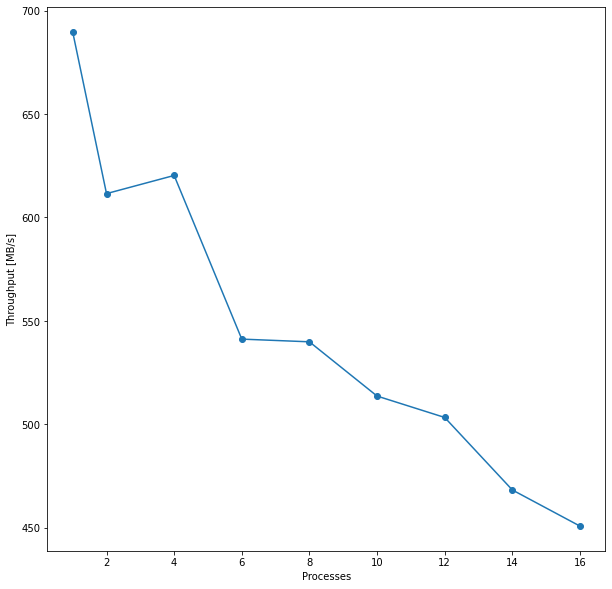

In [40]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["cores"], meantaskthroughput["readthroughput"], marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Throughput [MB/s]")

Text(0, 0.5, 'Time [s]')

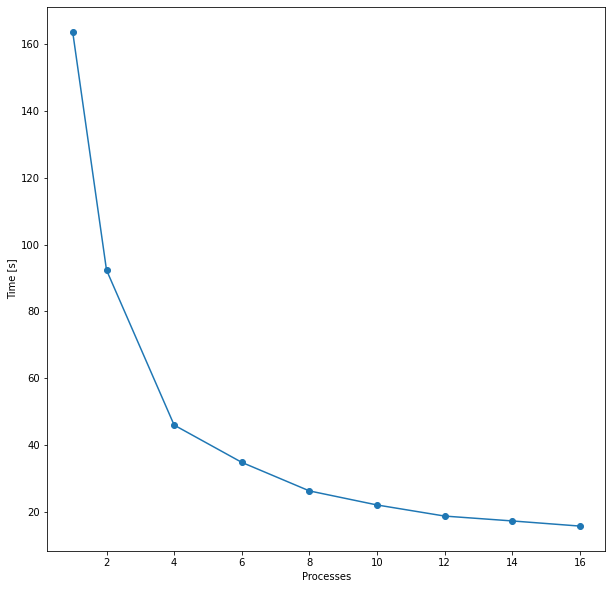

In [41]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["cores"], meantaskthroughput["taskreadtime_s"], marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Time [s]")

In [42]:
sumthroughput = df.groupby(["cores","taskid"]).mean()
sumthroughput = sumthroughput.reset_index().groupby(["cores"]).sum()
sumthroughput = sumthroughput.reset_index()
sumthroughput["totalthroughput"] = sumthroughput["readthroughput"] / 1024
sumthroughput["readthroughputspeedup"] = sumthroughput["readthroughput"] / sumthroughput["readthroughput"][0]
sumthroughput

,cores,taskid,taskruntime,taskreadtime,readthroughput,readpayload,totalthroughput,readthroughputspeedup
0,1,0,164.144556,1.637340e+11,689.666667,1.129408e+11,0.673503,1.000000
1,2,1,185.377222,1.848078e+11,1223.000000,1.129408e+11,1.194336,1.773320
2,4,6,184.869000,1.839076e+11,2481.111111,1.129408e+11,2.422960,3.597551
3,6,15,210.484778,2.088711e+11,3247.000000,1.129408e+11,3.170898,4.708072
4,8,28,212.168889,2.100947e+11,4318.888889,1.129408e+11,4.217665,6.262285
5,10,45,223.234222,2.205095e+11,5136.444444,1.129408e+11,5.016059,7.447720
6,12,66,227.659333,2.247002e+11,6039.555556,1.129408e+11,5.898003,8.757210
7,14,91,245.613556,2.417565e+11,6555.555556,1.129408e+11,6.401910,9.505397
8,16,120,255.950778,2.516178e+11,7212.555556,1.129408e+11,7.043511,10.458031


Text(0, 0.5, 'Throughput [GB/s]')

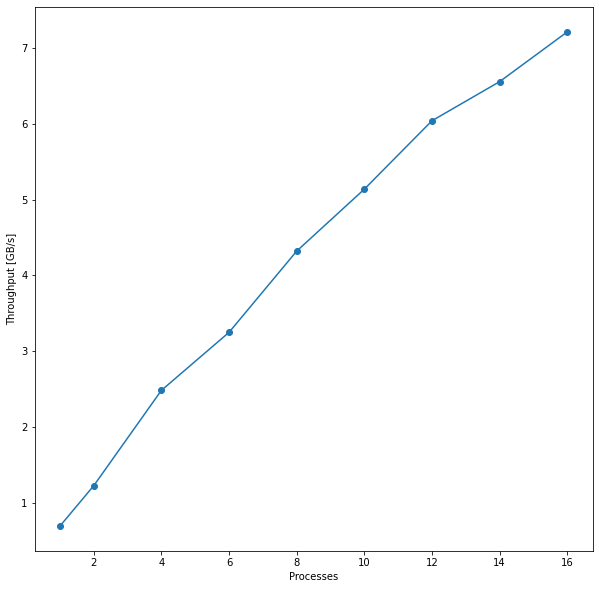

In [43]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["cores"], sumthroughput["readthroughput"]/1000, marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Throughput [GB/s]")

Text(0, 0.5, 'Throughput increase')

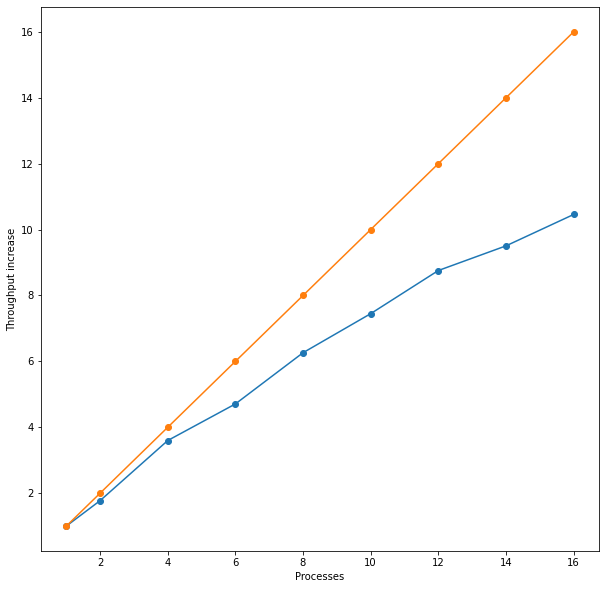

In [44]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["cores"], sumthroughput["readthroughputspeedup"], marker="o")
pyplot.plot(sumthroughput["cores"], sumthroughput["cores"], marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Throughput increase")

# TGraph

Info in <TCanvas::Print>: png file distrdf_lhcb_singlenode_processingthroughput.png has been created


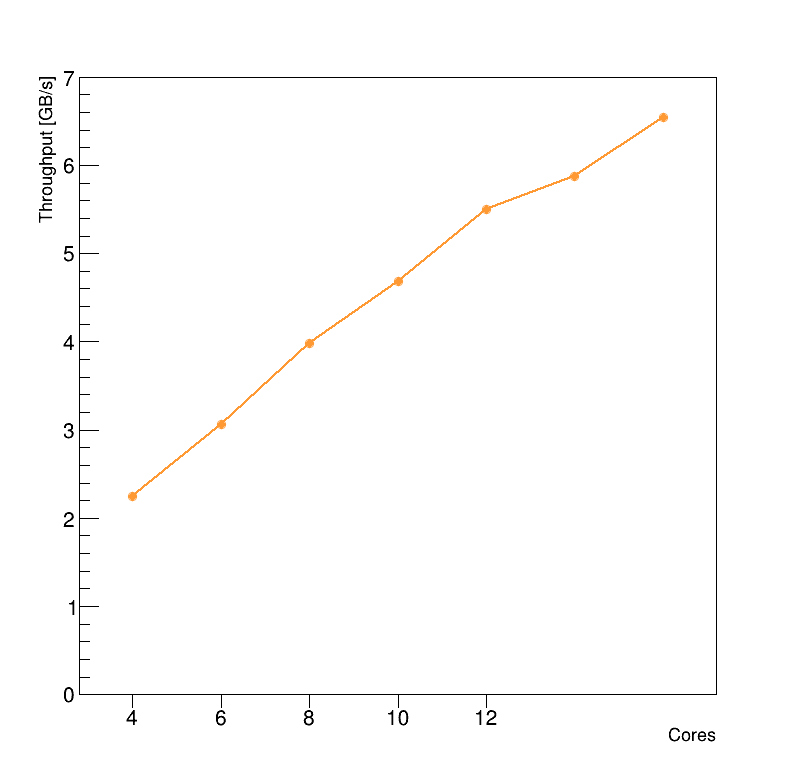

In [25]:
runtimegraph = ROOT.TGraph(len(timesdf["cores"]), numpy.array(timesdf["cores"], dtype=float), numpy.array(timesdf["throughput_GB_s"], dtype=float))

width = 800
height = 800
d = ROOT.TCanvas("d", "", width, height)

runtimegraph.SetTitle("")

runtimegraph.GetXaxis().SetTitle("Cores")
runtimegraph.GetXaxis().SetTitleSize(0.025)
runtimegraph.GetXaxis().SetTitleOffset(1.3)
runtimegraph.GetXaxis().SetLabelSize(0)
runtimegraph.GetXaxis().SetTickLength(0)

runtimegraph.GetYaxis().SetTitle("Throughput [GB/s]")
runtimegraph.GetYaxis().SetLabelSize(0.03)
runtimegraph.GetYaxis().SetTitleSize(0.025)
runtimegraph.GetYaxis().SetRangeUser(0, 7)

runtimegraph.SetMarkerStyle(20)
runtimegraph.SetMarkerSize(1)
runtimegraph.SetMarkerColor(ROOT.kOrange+1)

runtimegraph.SetLineStyle(ROOT.kSolid)
# Line color also decides error bar color somehow
runtimegraph.SetLineColorAlpha(ROOT.kOrange+1,1)
runtimegraph.SetLineWidth(2)
runtimegraph.Draw("APL")

ymin = runtimegraph.GetHistogram().GetMinimum()
ymax = runtimegraph.GetHistogram().GetMaximum()

dy = ymax - ymin
labels = []
ticks = []

for i in range(5):
    x = runtimegraph.GetPointX(i)
    t = ROOT.TLatex(x, ymin - 0.05 * dy, str(int(x)))
    t.SetTextSize(0.03)
    t.SetTextFont(42)
    t.SetTextAlign(21)
    t.Draw()
    labels.append(t)
    l = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    l.Draw()
    ticks.append(l)
    
d.Draw()
d.SaveAs("distrdf_lhcb_singlenode_processingthroughput.png")

Info in <TCanvas::Print>: png file distrdf_lhcb_singlenode_processingthroughputspeedup.png has been created


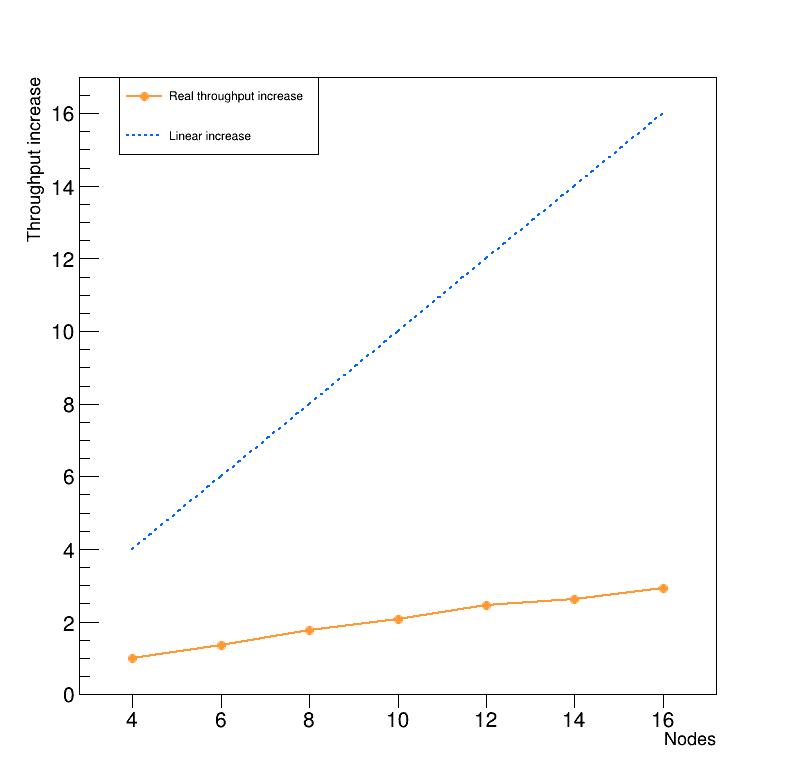

In [26]:
speedupgraph = ROOT.TGraph(len(timesdf["cores"]), numpy.array(timesdf["cores"], dtype=float), numpy.array(timesdf["throughputspeedup"], dtype=float))
idealspeedupgraph = ROOT.TGraph(len(timesdf["cores"]), numpy.array(timesdf["cores"], dtype=float), numpy.array(timesdf["cores"], dtype=float))

width = 800
height = 800
c = ROOT.TCanvas("c", "", width, height)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Nodes")
idealspeedupgraph.GetXaxis().SetTitleSize(0.025)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetYaxis().SetTitle("Throughput increase")

idealspeedupgraph.GetYaxis().SetTitleSize(0.025)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetYaxis().SetRangeUser(0, 17)
idealspeedupgraph.GetYaxis().SetLabelSize(0.03)

idealspeedupgraph.SetMarkerColor(ROOT.kAzure-3)
idealspeedupgraph.SetMarkerSize(1)
idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetLineStyle(ROOT.kDashed)
idealspeedupgraph.SetLineColorAlpha(ROOT.kAzure-3,1)
idealspeedupgraph.SetLineWidth(2)
idealspeedupgraph.Draw("AL")

ymin = idealspeedupgraph.GetHistogram().GetMinimum()
ymax = idealspeedupgraph.GetHistogram().GetMaximum()

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(timesdf["cores"])):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    xt = ROOT.TLatex(x, -0.9, str(int(x)))
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    xl.Draw()
    xticks.append(xl)

speedupgraph.SetMarkerStyle(20)
speedupgraph.SetMarkerSize(1)
speedupgraph.SetMarkerColor(ROOT.kOrange+1)


speedupgraph.SetLineColorAlpha(ROOT.kOrange+1,1)
speedupgraph.SetLineWidth(2)

speedupgraph.Draw("SAME PL")

legend = ROOT.TLegend(0.15,0.8,0.4,0.9)
legend.AddEntry(speedupgraph, "Real throughput increase")
legend.AddEntry(idealspeedupgraph, "Linear increase", "L")
legend.Draw()

c.Draw()
c.SaveAs("distrdf_lhcb_singlenode_processingthroughputspeedup.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: d
Info in <TCanvas::Print>: png file distrdf_lhcb_singlenode_readthroughput.png has been created


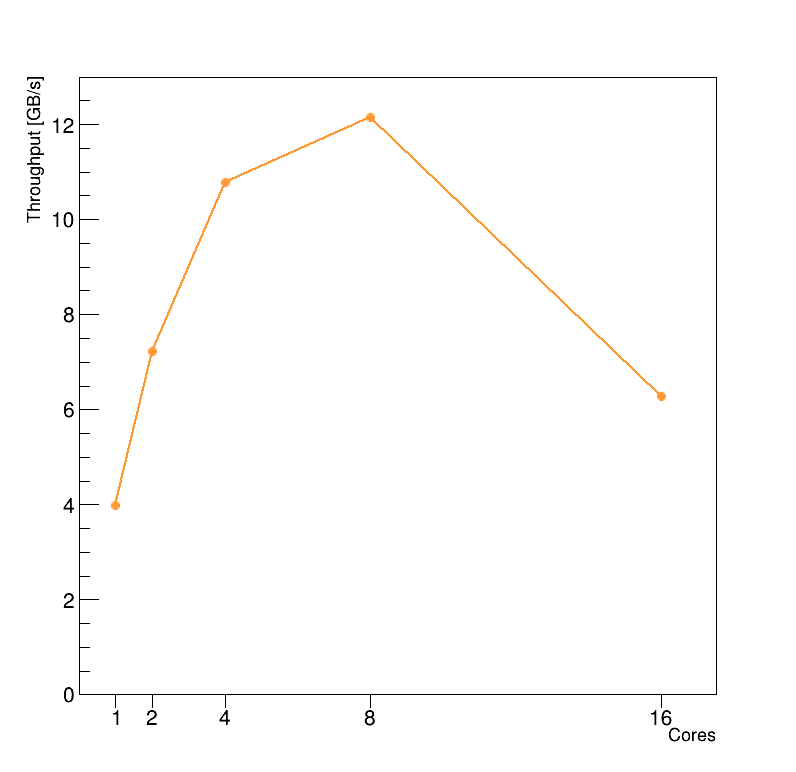

In [150]:
runtimegraph = ROOT.TGraph(len(sumthroughput["cores"]), numpy.array(sumthroughput["cores"], dtype=float), numpy.array(sumthroughput["readthroughput"]/1000, dtype=float))

width = 800
height = 800
d = ROOT.TCanvas("d", "", width, height)

runtimegraph.SetTitle("")

runtimegraph.GetXaxis().SetTitle("Cores")
runtimegraph.GetXaxis().SetTitleSize(0.025)
runtimegraph.GetXaxis().SetTitleOffset(1.3)
runtimegraph.GetXaxis().SetLabelSize(0)
runtimegraph.GetXaxis().SetTickLength(0)

runtimegraph.GetYaxis().SetTitle("Throughput [GB/s]")
runtimegraph.GetYaxis().SetLabelSize(0.03)
runtimegraph.GetYaxis().SetTitleSize(0.025)
runtimegraph.GetYaxis().SetRangeUser(0, 13)

runtimegraph.SetMarkerStyle(20)
runtimegraph.SetMarkerSize(1)
runtimegraph.SetMarkerColor(ROOT.kOrange+1)

runtimegraph.SetLineStyle(ROOT.kSolid)
# Line color also decides error bar color somehow
runtimegraph.SetLineColorAlpha(ROOT.kOrange+1,1)
runtimegraph.SetLineWidth(2)
runtimegraph.Draw("APL")

ymin = runtimegraph.GetHistogram().GetMinimum()
ymax = runtimegraph.GetHistogram().GetMaximum()

dy = ymax - ymin
labels = []
ticks = []

for i in range(len(sumthroughput["cores"])):
    x = runtimegraph.GetPointX(i)
    t = ROOT.TLatex(x, ymin - 0.05 * dy, str(int(x)))
    t.SetTextSize(0.03)
    t.SetTextFont(42)
    t.SetTextAlign(21)
    t.Draw()
    labels.append(t)
    l = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    l.Draw()
    ticks.append(l)
    
d.Draw()
d.SaveAs("distrdf_lhcb_singlenode_readthroughput.png")